In [1]:
import math
from io import BytesIO

import psycopg2
import postgis
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from solml import download

%matplotlib inline

In [2]:
database = 'solar'
database_user = 'solar'
database_password = 'solar'

In [3]:
connection = psycopg2.connect(dbname=database, user=database_user, password=database_password)
cursor = connection.cursor()
postgis.register(cursor)

cursor.execute("""
    select id_osm, commune, geom, merc, area, convex_hull_carto
    from buildings
    where id_osm=82089709
    ;
    """)

data = cursor.fetchall()

cursor.close()
connection.close()


In [4]:
example = data[0]
id_osm, commune, geom, merc, area, convex_hull_carto = example

In [5]:
def compute_angle(convex_hull_carto):
    assert convex_hull_carto.geojson['type'] == 'Polygon'
    assert len(convex_hull_carto.geojson['coordinates']) == 1
    
    rotation_90_degrees = np.array([[0, 1], [-1, 0]])
    
    points = np.array(convex_hull_carto.geojson['coordinates'][0])
    delta = points[1:] - points[:-1]
    distance = np.sqrt(np.power(delta[:,0:1], 2) + np.power(delta[:,1:2], 2))
    tangent = delta/distance
    normal = np.dot(tangent, rotation_90_degrees)
    proj_tangent = np.dot(points, tangent.T)
    proj_normal = np.dot(points, normal.T)
    
    tangent_min = proj_tangent.min(0)
    tangent_max = proj_tangent.max(0)
    normal_min = proj_normal.min(0)
    normal_max = proj_normal.max(0)
    
    length_tangent = tangent_max - tangent_min
    length_normal = normal_max - normal_min
    surface = length_tangent * length_normal
    
    i_orientation = surface.argmin()

    t_min = tangent_min[i_orientation]
    t_max = tangent_max[i_orientation]
    n_min = normal_min[i_orientation]
    n_max = normal_max[i_orientation]
    rectangle_local = np.array([[t_min, n_min], [t_min, n_max], [t_max, n_min], [t_max, n_max]])
    rotation_inverse = np.array([tangent[i_orientation], normal[i_orientation]])
    rectangle = np.dot(rectangle_local, rotation_inverse)
    
    #plt.scatter(rectangle[:,0], rectangle[:,1])
    #plt.scatter(points[:,0], points[:,1])
    #plt.axis('equal')
 
    size_tangent = t_max - t_min
    size_normal = n_max - n_min

    a, b = tangent[i_orientation]
    angle = math.acos(a)
    if b<0:
        angle *= -1
    angle += 2*math.pi
    while angle > math.pi/4.:
        angle -= math.pi/2.

    # angle in rad
    # rectangle in WebMercator
    # size of the rectangle in WebMercator
    return angle, rectangle, (size_normal, size_tangent)

In [9]:
def fetch_image(convex_hull_carto):
    angle, rectangle, size_WebMercator = compute_angle(convex_hull_carto)
   
    west, south = rectangle.min(0)
    east, north = rectangle.max(0)

    west, north = download.WebMercatorToWGS84(west, north)
    east, south = download.WebMercatorToWGS84(east, south)

    original_array = download.fetch_box(west, east, north, south, border=15)
    original_image = Image.fromarray(original_array)
    
    buffer = BytesIO()
    original_image.save(buffer, 'JPEG')
    original_bytes = buffer.getvalue()

    return original_bytes, angle, size_WebMercator

In [10]:
original_bytes, angle, size_WebMercator = fetch_image(convex_hull_carto)
buffer = BytesIO(original_bytes)
original_image = Image.open(buffer)

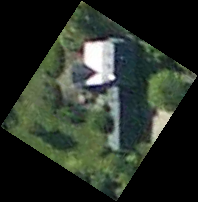

In [12]:
angle_degree = angle * 180. / math.pi
straight_image = original_image.rotate(-angle_degree, resample=Image.BICUBIC, expand=True)
straight_array = np.asarray(straight_image)
straight_size_X, straight_size_Y, _ = straight_array.shape
straight_image

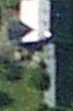

In [13]:
size_X = size_WebMercator[0] / download.pixelSizeX
size_Y = - size_WebMercator[1] / download.pixelSizeY
size_X_with_border = int(math.ceil(size_X + 10))
size_Y_with_border = int(math.ceil(size_Y + 10))
offset_X = int((straight_size_X / 2.) - (size_X_with_border / 2.))
offset_Y = int((straight_size_Y / 2.) - (size_Y_with_border / 2.))
cropped_array = straight_array[offset_Y:offset_Y+size_Y_with_border, offset_X:offset_X+size_X_with_border]
cropped_image = Image.fromarray(cropped_array)
cropped_image